## Module imports

In [2]:
# this is a bit of a hack to get relative imports
# to work as if these notebooks were in a package
# change cwd to project root if 'notebooks' in PATH
from os import chdir
from pathlib import Path

if "notebooks" in str(Path.cwd()):
    chdir("..")


import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings 
import yaml



import src.constants as const
from src.schemas import DataCatalog
from src.various_methods import (
    PlotCounter,
    month_num_to_cos,
    month_num_to_sin,
    get_workingdays,
    is_working_day
)
from src.simulation_schemas import PopulationScenarios


## Notebook Constants

In [3]:
OLD_AGE_OVER = 65
WORKING_AGE = 20
REGIONAL_APPOINTMENTS_CATALOG_NAME = "NHS GP Appointments by Region"
HISTORICAL_APPOINTMENTS_CATALOG_NAME = "NHS GP Appointments by Region, historical"
GP_LIST_NAME = "Patients Registered at a GP practice, October 2023"
APPOINTMENTS_START_DATE = dt.date(2022, 4, 1)
NOTEBOOK_ALIAS = "num_appointments_timeseries"

## Load Catalog

In [4]:
# load data catalog
catalog = DataCatalog.load_from_yaml("data_catalog.yaml")
plot_counter = PlotCounter(name=NOTEBOOK_ALIAS)

# Data loading
## Appointments SUB-ICB level

In [5]:
USED_APPOINTMENT_COLUMNS = ["SUB_ICB_LOCATION_CODE","APPOINTMENT_MONTH","HCP_TYPE","COUNT_OF_APPOINTMENTS"]

In [6]:
def load_all_areas_gp_appts(catalog_entry_name:str) ->pd.DataFrame:
    # load catalogue entry
    catalog_entry = catalog.get_catalog_entry_by_name(catalog_entry_name)
    _ = catalog_entry.load()

    # load all areas
    dfs_ = []
    for ccg_name in catalog_entry.zip_file.namelist():
        catalog_entry.csv_file = ccg_name
        dfs_.append(catalog_entry.load())
    # combine all areas
    combined_df_ = pd.concat(dfs_, axis=0)
    # rename cols
    combined_df_ = combined_df_.rename(columns={'CCG_CODE':'SUB_ICB_LOCATION_CODE',
                                                          'Appointment_Month':'APPOINTMENT_MONTH'})
    # filter cols to the ones we actually need
    combined_df_ = combined_df_.loc[:,USED_APPOINTMENT_COLUMNS]
    # convert to dt
    try:
        combined_df_['APPOINTMENT_MONTH'] = pd.to_datetime(combined_df_['APPOINTMENT_MONTH'])
    except:
        combined_df_['APPOINTMENT_MONTH'] = pd.to_datetime(combined_df_['APPOINTMENT_MONTH'], format='%b-%y')
    
    return combined_df_

# load latest
latest_gp_appts_df = load_all_areas_gp_appts(REGIONAL_APPOINTMENTS_CATALOG_NAME)
# load historical
historical_gp_appts_df = load_all_areas_gp_appts(HISTORICAL_APPOINTMENTS_CATALOG_NAME)
# filter out the months that are in the latest to ensure no overlap/ duplicates
historical_gp_appts_df = historical_gp_appts_df.loc[~historical_gp_appts_df['APPOINTMENT_MONTH'].isin(latest_gp_appts_df['APPOINTMENT_MONTH'].unique())]

# combine the two into one df

all_area_appts_df = pd.concat([latest_gp_appts_df, historical_gp_appts_df], axis=0)

print(all_area_appts_df.dtypes)
all_area_appts_df.head()

/tmp/ipykernel_3012/505712588.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_df_['APPOINTMENT_MONTH'] = pd.to_datetime(combined_df_['APPOINTMENT_MONTH'])


SUB_ICB_LOCATION_CODE            object
APPOINTMENT_MONTH        datetime64[ns]
HCP_TYPE                         object
COUNT_OF_APPOINTMENTS             int64
dtype: object


/tmp/ipykernel_3012/505712588.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_df_['APPOINTMENT_MONTH'] = pd.to_datetime(combined_df_['APPOINTMENT_MONTH'])


,SUB_ICB_LOCATION_CODE,APPOINTMENT_MONTH,HCP_TYPE,COUNT_OF_APPOINTMENTS
0,02T,2021-11-01,GP,2258
1,02T,2021-11-01,GP,633
2,02T,2021-11-01,GP,4791
3,02T,2021-11-01,GP,296
4,02T,2021-11-01,GP,1871


## GP List 

In [7]:
gp_list_df = catalog.get_catalog_entry_by_name("Patients Registered at a GP practice, October 2023").load()

/workspaces/PrimaryCareDemandAndCapacity/src/schemas.py:146: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_file, **read_csv_kwargs)


In [8]:
# get number of patients
n_patients_df = (
    gp_list_df.loc[
        (gp_list_df['ORG_CODE'].isin(const.SUB_ICB_CODES.keys()))
        & (gp_list_df['SEX']=='ALL') 
        & (gp_list_df['AGE_GROUP_5']=='ALL'),['ORG_CODE','NUMBER_OF_PATIENTS']]
    .set_index('ORG_CODE')
    .sort_index())

## EDA

In [9]:
# divide by working days/month to get average appointments per day
monthly_appts_df = all_area_appts_df.groupby('APPOINTMENT_MONTH').sum(numeric_only=True)
monthly_appts_df = monthly_appts_df.assign(WORKING_DAYS=get_workingdays(monthly_appts_df.index))
monthly_appts_df = monthly_appts_df.assign(AVG_APPTS_PER_WORKING_DAY=monthly_appts_df['COUNT_OF_APPOINTMENTS'] / monthly_appts_df['WORKING_DAYS'])

### Clear seasonality (12 months) in SNEE - When looking at average number of appointments per working day

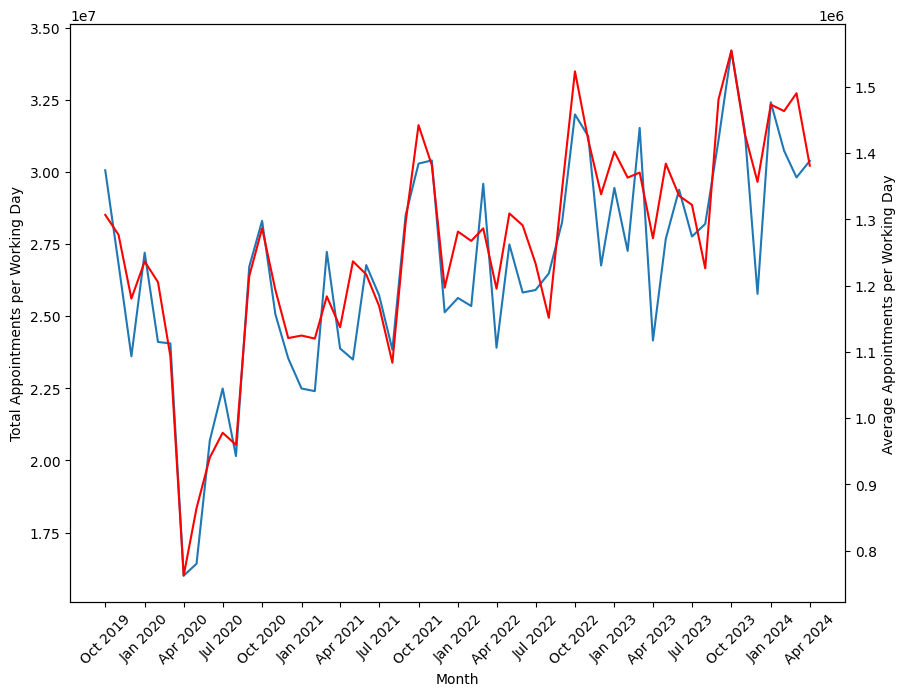

In [10]:
fig, ax = plt.subplots(figsize=(10, 7.5))
ax2 = ax.twinx()
ax.plot(monthly_appts_df['COUNT_OF_APPOINTMENTS'])
ax2.plot(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], color='r')
# y axis title
ax2.set_ylabel('Average Appointments per Working Day')
# x axis title
ax.set_ylabel('Total Appointments per Working Day')
# x axis title
ax.set_xlabel('Month')

# change x axis format to month, year
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
# rotate x axis labels
ax.tick_params(axis='x', rotation=45)
plt.show()

### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)


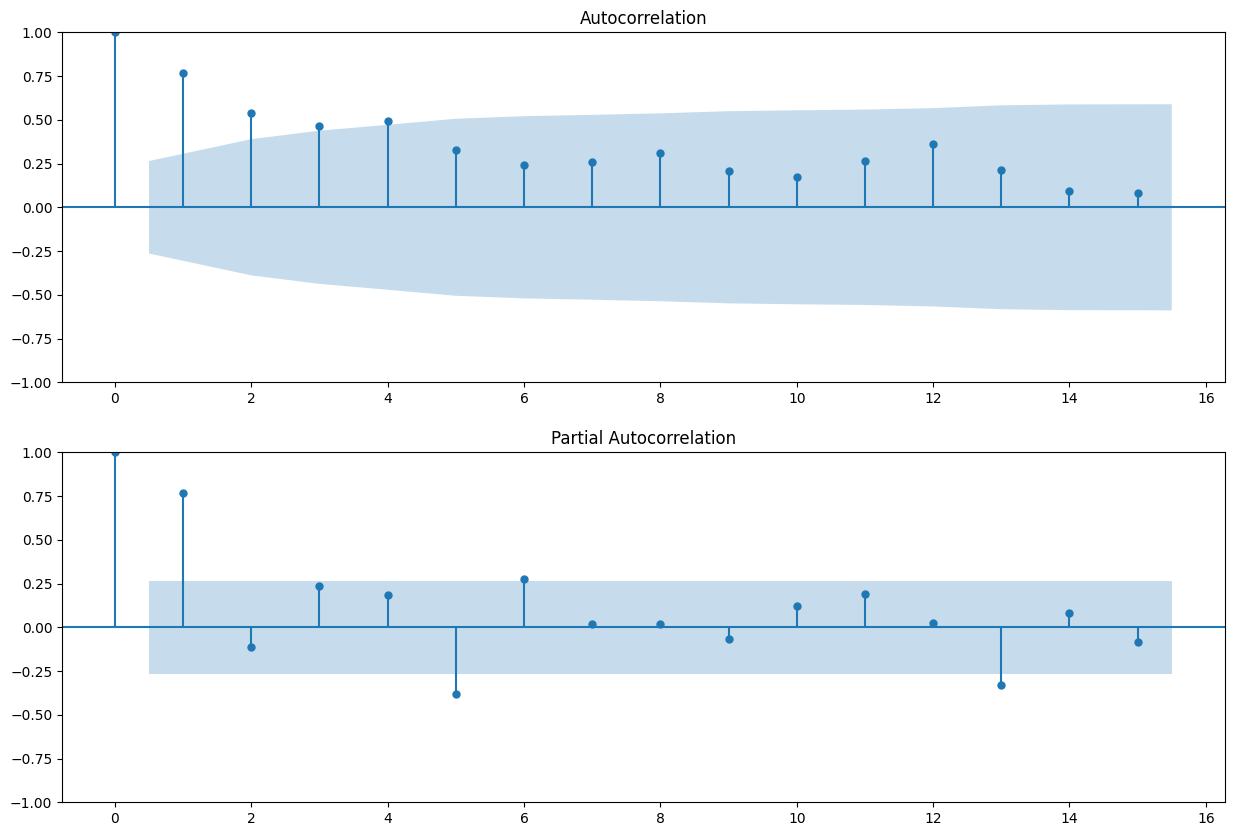

In [11]:


# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], lags=15, ax=ax[0])
plot_pacf(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], lags=15, ax=ax[1])
plt.show()


- The strong autocorrelation at lag 1 and the slower decay over several months suggest a dominant trend component. When a time series has a strong upward or downward trend, it can mask the seasonal patterns, especially if the trend is strong relative to the magnitude of the seasonal fluctuations.
- If there's yearly seasonality (i.e., a pattern every 12 months), we'd expect to see significant autocorrelation at lags 12 or multiples of 12. However, this isn't obvious here. The autocorrelation tapers off more gradually and doesn't spike again at lag 12, which could imply that the trend is overpowering or blending with the seasonal effects.


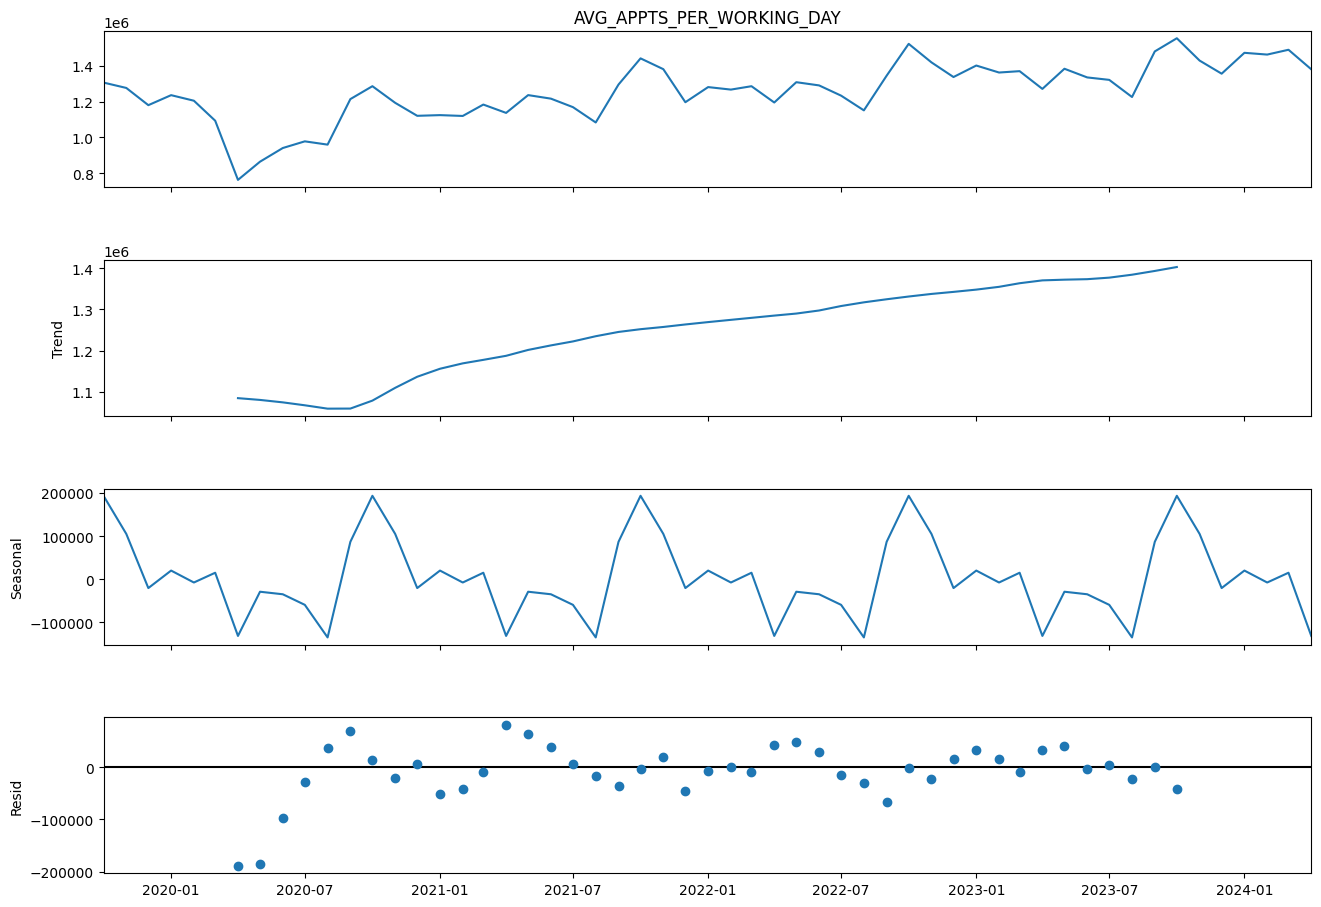

In [12]:
# Decompose the time series

result = seasonal_decompose(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], model='additive', period=12)

# Plot the decomposition
fig = result.plot()
fig.set_size_inches(15, 10)
plt.show()

- The upward trend is strong and clearly visible, which aligns with earlier thoughts that the trend might be washing out the seasonality in the raw data.
    - There is a repeating yearly seasonal pattern, but it's smaller in magnitude compared to the trend.
    - With the trend separated, the seasonality becomes more apparent, confirming that a yearly seasonal component exists but was being masked by the strong trend.
    - When modelling this time series, a model like SARIMA (Seasonal ARIMA) or another time series model with both trend and seasonality components would be appropriate.

In [13]:
# split out models from the national data
snee_monthly_df = all_area_appts_df.groupby(['SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH']).sum(numeric_only=True).reset_index().query('SUB_ICB_LOCATION_CODE in @const.SUB_ICB_CODES.keys()')
# calc appointments per
# snee_monthly_df = snee_monthly_df.assign(WORKING_DAYS=))
snee_monthly_df = snee_monthly_df.assign(AVG_APPTS_PER_WORKING_DAY=snee_monthly_df['COUNT_OF_APPOINTMENTS'] / get_workingdays(snee_monthly_df['APPOINTMENT_MONTH'].dt))
                                         
# divide by working days/month to get average appointments per day
monthly_dfs = {}
for sub_icb in snee_monthly_df['SUB_ICB_LOCATION_CODE'].unique():
    monthly_dfs[sub_icb] = snee_monthly_df.query('SUB_ICB_LOCATION_CODE == @sub_icb').set_index('APPOINTMENT_MONTH').sort_index()
    monthly_dfs[sub_icb] = monthly_dfs[sub_icb].asfreq('MS')

In [20]:

warnings.filterwarnings('ignore')

models = {}
for sub_icb, df in monthly_dfs.items():
    # Define the seasonal order (S = 12 for yearly seasonality)
    seasonal_order = (1, 1, 1, 12)  # This is an initial guess, to be refined with AIC

    # Fit SARIMA model
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_mdl = None
    
    best_exp_aic = np.inf
    best_trend =None
    best_seasonal = None
    best_exp_mdl = None

    # Loop through different combinations of (p, d, q) and (P, D, Q)
    for p in range(1, 4):
        for d in range(0, 2):
            for q in range(1, 2):
                for P in range(0, 2):
                    for D in range(0, 2):
                        for Q in range(0,1):
                            try:
                                tmp_mdl = SARIMAX(df['AVG_APPTS_PER_WORKING_DAY'], order=(p, d, q),
                                                seasonal_order=(P, D, Q, 12)).fit(verbose=False, disp=False)
                                tmp_aic = tmp_mdl.aic
                                if tmp_aic < best_aic:
                                    best_aic = tmp_aic
                                    best_order = (p, d, q)
                                    best_seasonal_order = (P, D, Q, 12) # s=12 for yearly seasonality
                                    best_mdl = tmp_mdl
                            except:
                                # often we will have errors when fitting the model
                                continue
    try:
        for seasonal in ['add','mul']:
            for trend in ['add','mul']:
                exp_mdl = ExponentialSmoothing(df['AVG_APPTS_PER_WORKING_DAY'], trend=trend, seasonal=seasonal,seasonal_periods=12).fit()
                if exp_mdl.aic < best_exp_aic:
                    best_trend = trend
                    best_seasonal = seasonal
                    best_exp_mdl = exp_mdl  
                    
                    
        print(f'Best Exponential Smoothing model | AIC: {best_exp_mdl.aic}')
    except:
        continue
    models[sub_icb] = {'model':best_mdl,'AIC':best_aic,'order':best_order,'seasonal_order': best_seasonal_order}
    print(f'Best SARIMA order: {best_order} Seasonal order: {best_seasonal_order} | AIC: {best_aic}')

Best Exponential Smoothing model | AIC: 692.9591176514547
Best SARIMA order: (2, 1, 1) Seasonal order: (1, 1, 0, 12) | AIC: 648.006383471879
Best Exponential Smoothing model | AIC: 678.1410227087124
Best SARIMA order: (3, 1, 1) Seasonal order: (1, 1, 0, 12) | AIC: 637.1684271072768
Best Exponential Smoothing model | AIC: 665.7966231878166
Best SARIMA order: (3, 1, 1) Seasonal order: (1, 1, 0, 12) | AIC: 618.7035627395062


06L AIC: 648.006383471879


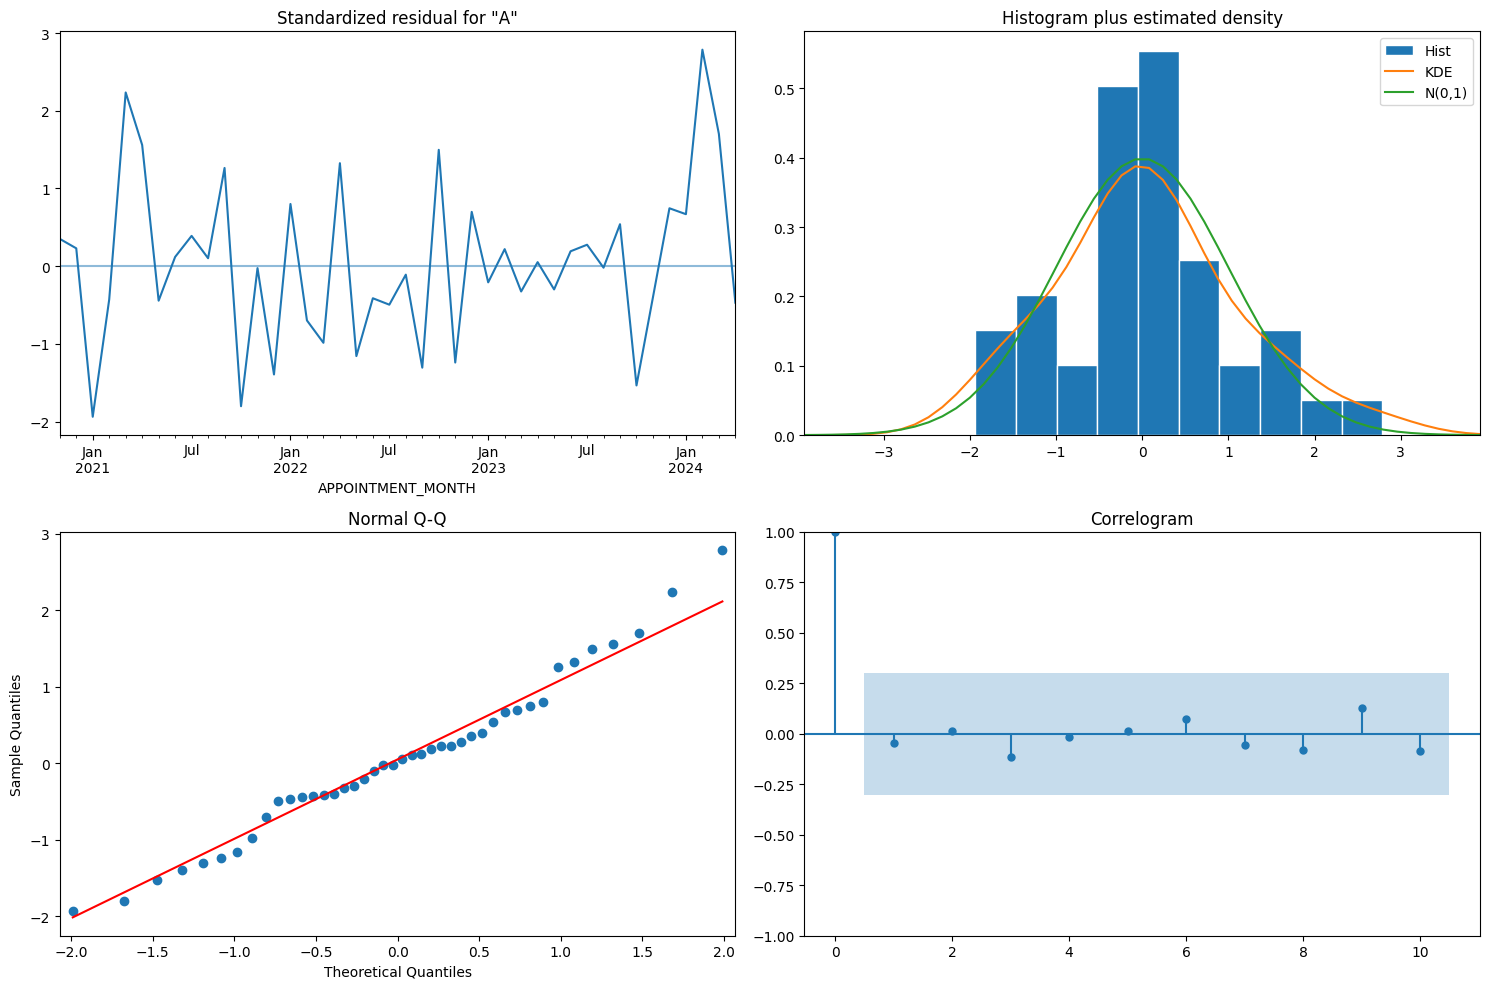

06T AIC: 637.1684271072768


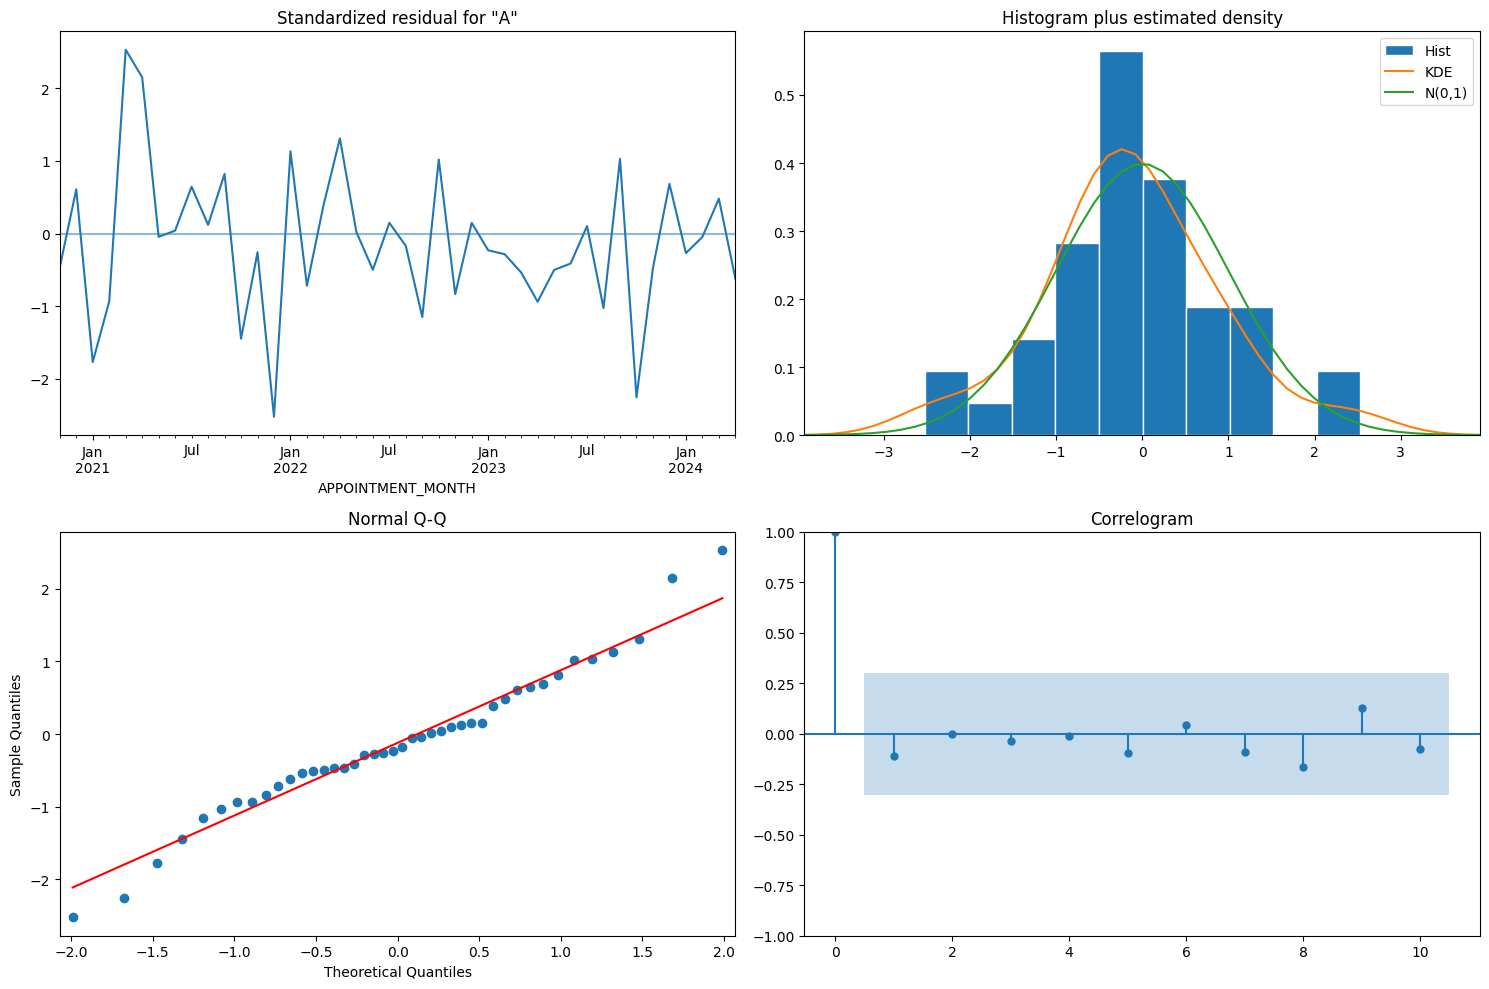

07K AIC: 618.7035627395062


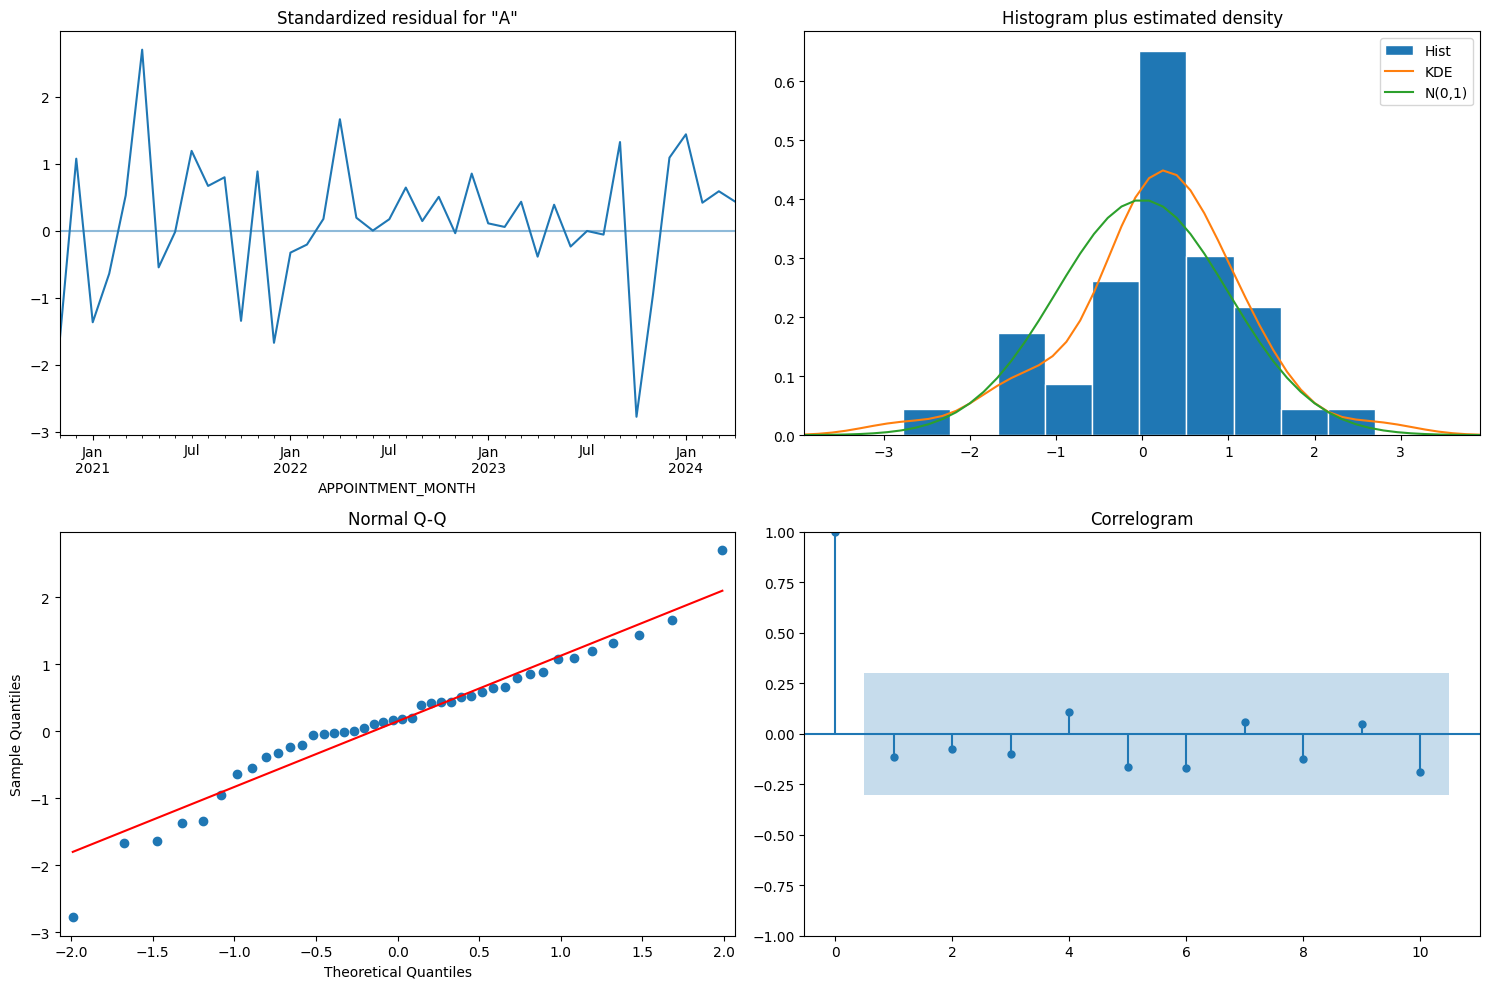

In [41]:
for sub_icb, model in models.items():
    print(f'{sub_icb} AIC: {model["AIC"]}')
    fig = model['model'].plot_diagnostics(figsize=(15, 10))
    plt.tight_layout()
    plt.show()

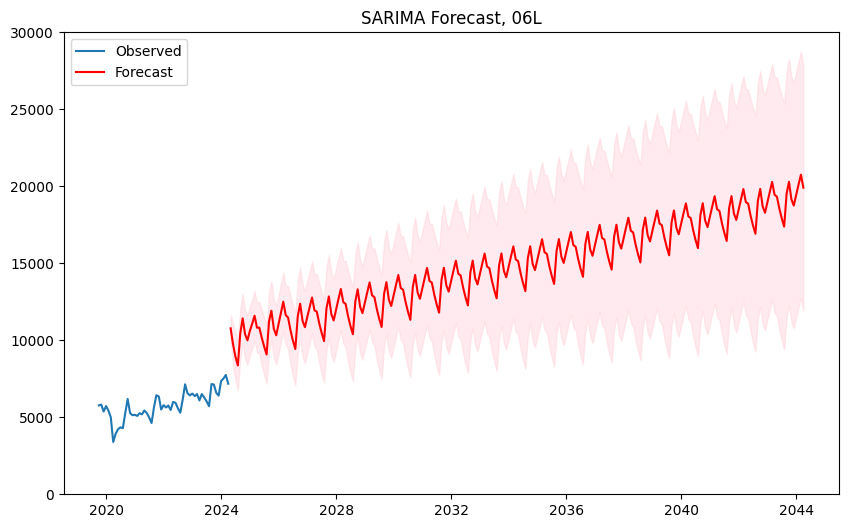

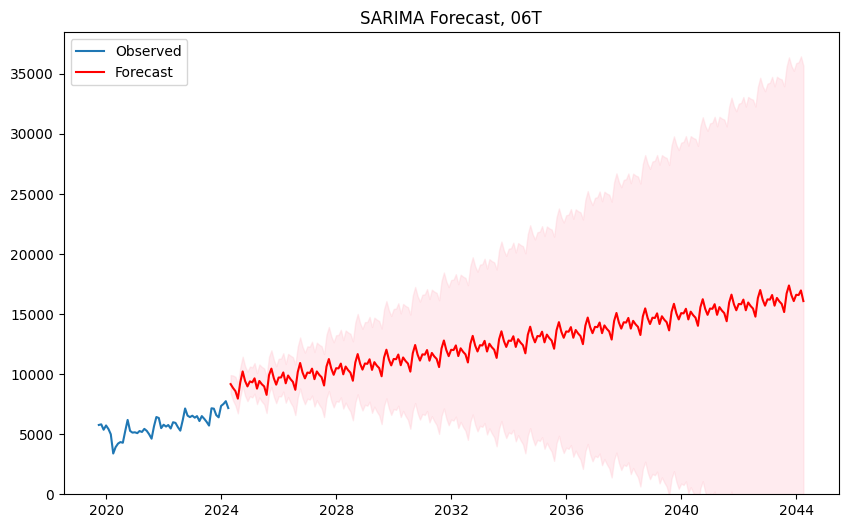

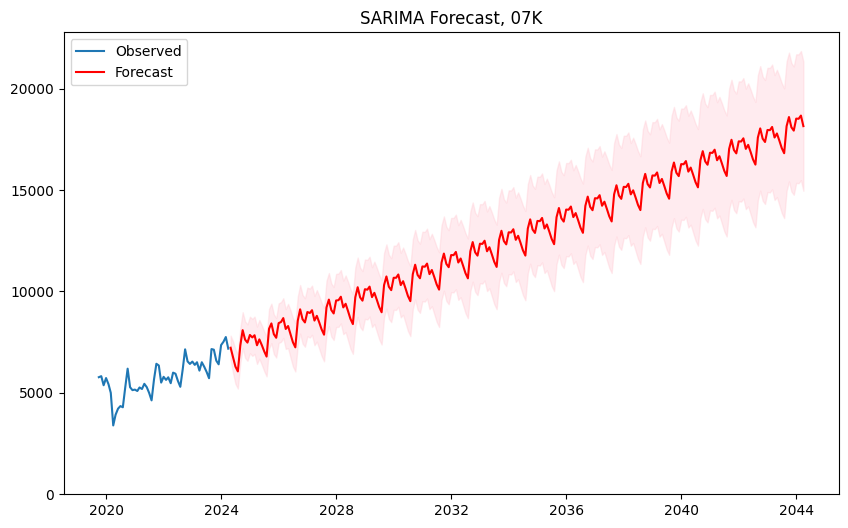

In [44]:
forecasts = {}
for sub_icb, best_mdl in models.items(): 
    # Forecast next 12 months
    forecast = best_mdl['model'].get_forecast(steps=20*12)
    forecasts[sub_icb] = forecast
    forecast_values = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()
    
    class SARIMAForecastPlotter:
        def __init__(self, model, observed_data, forecast_values, confidence_intervals, sub_icb):
            self.model = model
            self.observed_data = observed_data
            self.forecast_values = forecast_values
            self.confidence_intervals = confidence_intervals
            self.sub_icb = sub_icb

        def plot_forecast(self):
            plt.figure(figsize=(10, 6))
            plt.plot(self.observed_data.index, self.observed_data['AVG_APPTS_PER_WORKING_DAY'], label='Observed')
            plt.plot(self.forecast_values.index, self.forecast_values, label='Forecast', color='red')
            plt.fill_between(self.confidence_intervals.index,
                             self.confidence_intervals.iloc[:, 0],
                             self.confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
            plt.legend()
            plt.title(f'SARIMA Forecast, {self.sub_icb}')
            plt.ylim(bottom=0)  # Set y-axis to begin at 0
            plt.show()

    # Create and use the SARIMAForecastPlotter
    plotter = SARIMAForecastPlotter(best_mdl['model'], df, forecast_values, confidence_intervals, sub_icb)
    plotter.plot_forecast()


## Find total appointments/day

- We need to convert from average appointments/ day to appointments/day
- Only working days should have appointments.

In [63]:
daily_forecasts = {}
for sub_icb, forecast in forecasts.items():
        monthly_forecasts =forecasts[sub_icb].predicted_mean
        dates = pd.date_range(start=monthly_forecasts.index[0].date(), end=monthly_forecasts.index[-1].date(), freq='D')
        daily_df = (pd.DataFrame(index=dates) # create from daily index
                .assign(month=lambda df: pd.to_datetime(df.index.map(lambda x: x.replace(day=1))), # create a month column to join
                        is_working_day=lambda df: df.index.map(is_working_day)) # add a working day column
                .join(monthly_forecasts, on='month')) # bring in the monthly (appointments per working day)

        # on non-working days, set the forecast to 0    
        daily_df.loc[daily_df['is_working_day']==False,'predicted_mean'] = 0
        daily_df['predicted_mean'] = daily_df['predicted_mean'].astype(int)
        daily_df = daily_df.rename(columns={'predicted_mean':'n_appointments'})
        daily_df.index = daily_df.index.date
        daily_forecasts[sub_icb] = daily_df['n_appointments'].to_dict()

### Output the forecasts
#### Schema:
```yaml

- 06L # area
  - 2024-06-01 : 66669 # date : forecast
  ...
...
```

In [64]:
with open("forecasts-SARIMA.yaml", "w") as output_:
    yaml.dump(daily_forecasts, output_)